The BigMart sales dataset is a popular dataset used in machine learning and regression tasks. It contains information about sales data of various products in different BigMart stores. The dataset is often used to predict the sales of products based on different features.

Here is a brief description of the attributes in the BigMart sales dataset:

1. Item_Identifier: Unique identifier for each product (categorical).
2. Item_Weight: Weight of the product (numeric).
3. Item_Fat_Content: Whether the product is low fat or regular (categorical).
4. Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product (numeric).
5. Item_Type: The category of the product (categorical).
6. Item_MRP: Maximum Retail Price (MRP) of the product (numeric).
7. Outlet_Identifier: Unique identifier for each store (categorical).
8. Outlet_Establishment_Year: The year in which the store was established (numeric).
9. Outlet_Size: The size of the store (categorical).
10. Outlet_Location_Type: The type of location where the store is situated (categorical).
11. Outlet_Type: The type of outlet (categorical).
12. Item_Outlet_Sales: The sales of the product in the particular store (numeric).

The challenge in working with the BigMart sales dataset is to build a regression model that accurately predicts the sales of products based on the given features. This can be a challenging task due to the presence of missing values, categorical variables, and the need to handle outliers and skewed distributions. Additionally, feature engineering techniques may be required to extract meaningful information from the given attributes and improve the model's performance.


# import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

#load the dataset

In [ ]:
"""
!gdown --id 1l_pRxlRHqe9NY64-PiB6KFGmNlPwDgfR
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 'BigMart-Sales-Data'

"""

403 - Forbidden - Permission 'competitions.participate' was denied


In [ ]:
!gdown --id 1VZ2oDw9h7yUiBuCblJQvpA2kcmt5X1I_
data = pd.read_csv('/content/Train.csv')

In [ ]:
data.sample(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7995,FDO20,12.850,Regular,0.152748,Fruits and Vegetables,252.0382,OUT018,2009,Medium,Tier 3,Supermarket Type2,4037.4112
3198,DRJ51,14.100,Low Fat,0.088172,Dairy,232.2668,OUT045,2002,NaN,Tier 2,Supermarket Type1,4146.6024
7283,DRE60,9.395,Low Fat,0.159304,Soft Drinks,226.1720,OUT035,2004,Small,Tier 2,Supermarket Type1,3848.3240
2885,FDZ52,19.200,Low Fat,0.100641,Frozen Foods,112.6886,OUT017,2007,NaN,Tier 2,Supermarket Type1,1779.0176
496,FDW28,18.250,low fat,0.088750,Frozen Foods,196.5452,OUT013,1987,High,Tier 3,Supermarket Type1,2348.9424


#EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
data.shape

(8523, 12)

In [4]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

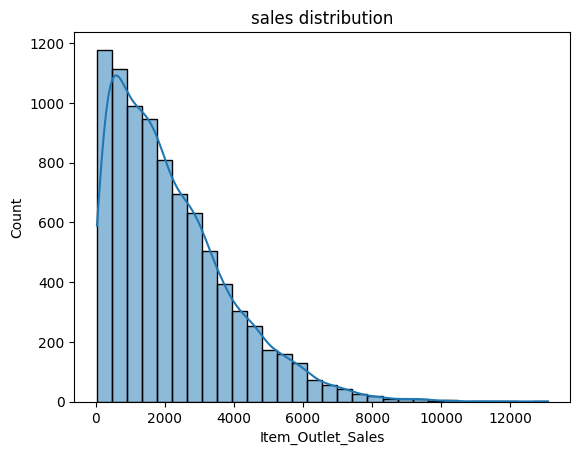

In [ ]:
sns.histplot(data['Item_Outlet_Sales'], kde=True, bins=30)
plt.title('sales distribution')
plt.show()

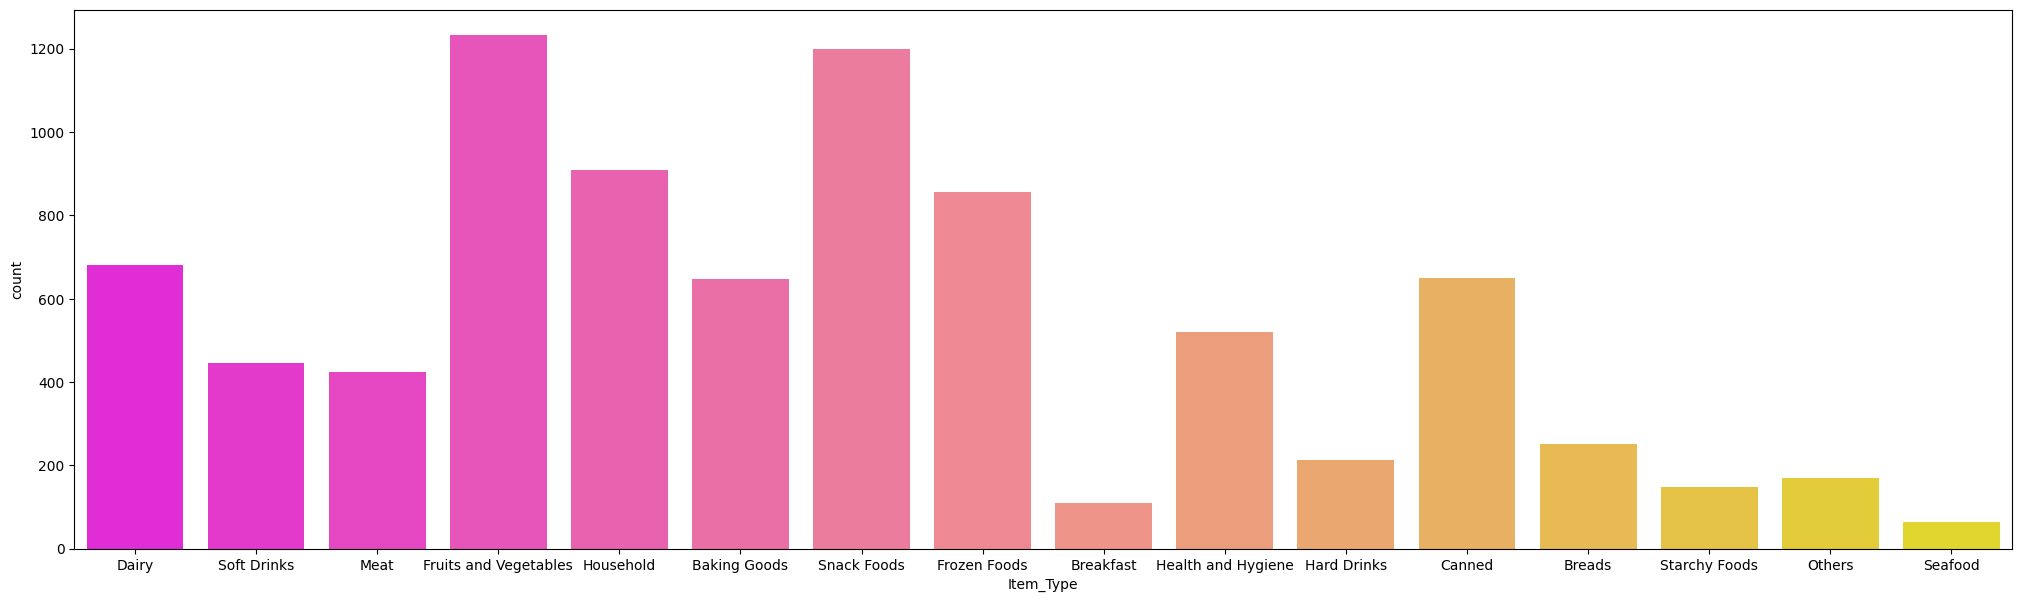

In [42]:
plt.figure(figsize=(25,7))
sns.countplot(x=data['Item_Type'],palette='spring')
plt.show()

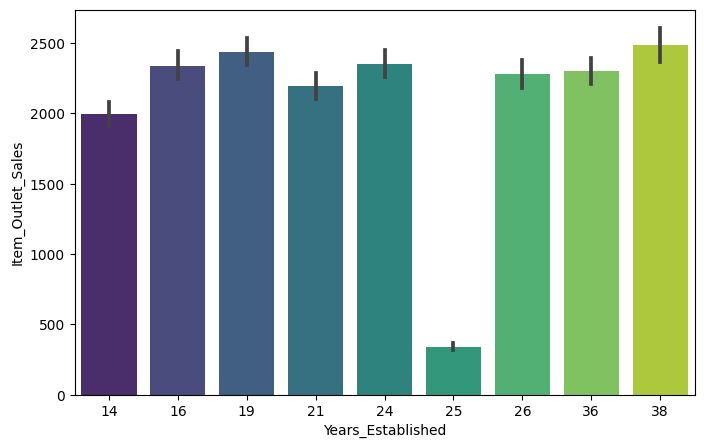

In [52]:
data['Years_Established'] = data['Outlet_Establishment_Year'].apply(lambda x: 2023 - x)
plt.figure(figsize=(8,5))
sns.barplot(x=data['Years_Established'],y=data['Item_Outlet_Sales'],palette='viridis')
plt.show()

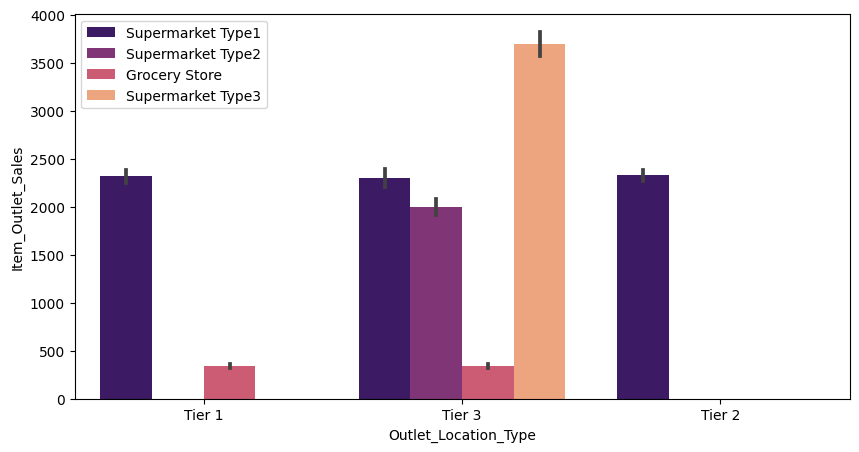

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(x=data['Outlet_Location_Type'],y=data['Item_Outlet_Sales'],hue=data['Outlet_Type'],palette='magma')
plt.legend()
plt.show()

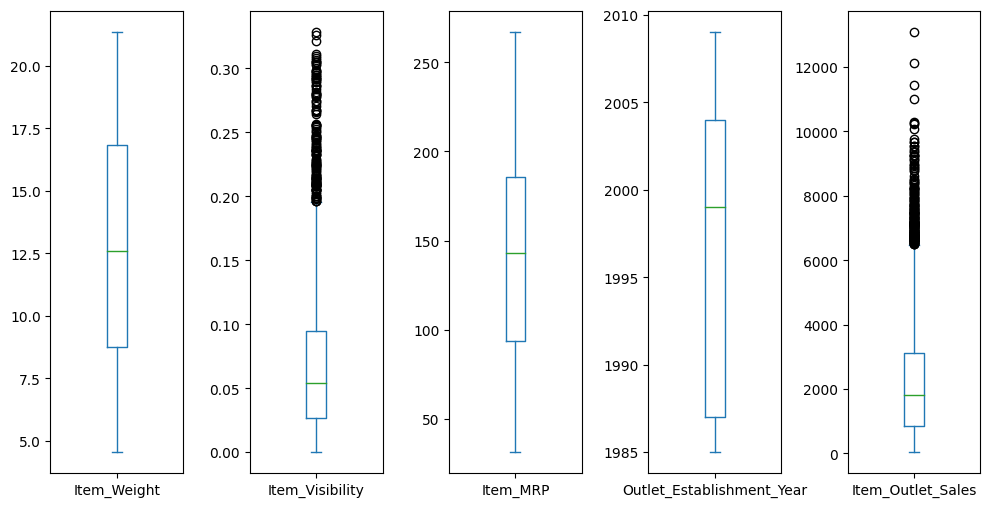

In [62]:
data.select_dtypes('number').plot(kind='box', subplots=True,sharey=False,figsize=(12,6))
plt.subplots_adjust(wspace=0.5);

In [67]:
df=data[['Item_Outlet_Sales','Item_Visibility']]
for k, v in df.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column Item_Outlet_Sales outliers = 2.18%
Column Item_Visibility outliers = 1.69%


#data preprocessing

clean Outliers in: Item Visibility and Outlet Sales

In [73]:
upper1 = data['Item_Visibility'].quantile(0.95)
data = data[~(data['Item_Visibility'] > upper1)]
upper2 = data['Item_Outlet_Sales'].quantile(0.95)
data = data[~(data['Item_Outlet_Sales'] > upper2)]


In [ ]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [17]:
data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)
data['Item_Weight'].fillna(value=np.mean(data['Item_Weight']), inplace=True)

In [ ]:
data.duplicated().sum()

0

In [54]:
data['Item_Fat_Content'].unique()
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'Low Fat': 0,'low fat': 0,'LF': 0, 'reg': 1, 'Regular': 1})

data['Outlet_Size'].unique()
data['Outlet_Size'] = data['Outlet_Size'].replace({'Small': 0,'Medium': 1,'High': 2})

data['Outlet_Location_Type'].unique()
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].replace({'Tier 3': 0,'Tier 2': 1,'Tier 1': 2})

data['Outlet_Type'].unique()
data['Outlet_Type'] = data['Outlet_Type'].replace({'Grocery Store': 0,'Supermarket Type1': 1,'Supermarket Type2': 2,'Supermarket Type3': 3})

le = LabelEncoder()
data['Item_Type'] = le.fit_transform(data['Item_Type'])

#data = pd.get_dummies(data, columns=['Item_Type'])

In [55]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                      int64
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                  float64
Outlet_Location_Type           int64
Outlet_Type                    int64
Item_Outlet_Sales            float64
Years_Established              int64
dtype: object

In [56]:
data.describe()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Established
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,6113.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.352693,0.066132,7.226681,140.992782,1997.831867,0.761819,0.887129,1.201220,2181.288914,25.168133
std,4.643456,0.477836,0.051598,4.209990,62.275067,8.371760,0.697463,0.812757,0.796459,1706.499616,8.371760
min,4.555000,0.000000,0.000000,0.000000,31.290000,1985.000000,0.000000,0.000000,0.000000,33.290000,14.000000
25%,8.773750,0.000000,0.026989,4.000000,93.826500,1987.000000,0.000000,0.000000,1.000000,834.247400,19.000000
50%,12.600000,0.000000,0.053931,6.000000,143.012800,1999.000000,1.000000,1.000000,1.000000,1794.331000,24.000000
75%,16.850000,1.000000,0.094585,10.000000,185.643700,2004.000000,1.000000,2.000000,1.000000,3101.296400,36.000000
max,21.350000,1.000000,0.328391,15.000000,266.888400,2009.000000,2.000000,2.000000,3.000000,13086.964800,38.000000


#feature engineering

<ipython-input-57-ecba06bb21a1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr().abs(),  annot=True);


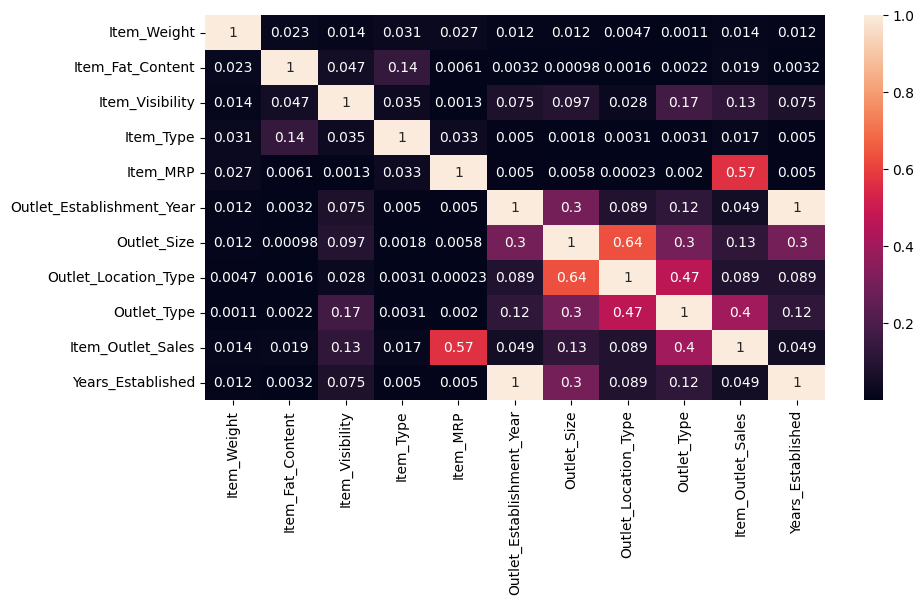

In [57]:
plt.figure(figsize=(10, 5))
sns.heatmap(data.corr().abs(),  annot=True);

From correlation matrix, we see Outlet_Size and Outlet_Location_Type are highly correlated features. The columns Outlet_Type, Item_MRP has a correlation score about 0.5 with MEDV which is a good indication of using as predictors.

There are some columns that needs to be dropped as they don't seem helping our analysis.

In [76]:
data = data.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)

#training

#predict and evaluate the model

In [ ]:
#mse = mean_squared_error(y_test,y_pred)         print("mean squared error:",mse)
#from math import sqrt     rmse = sqrt(mse)      print("Root Mean Squared Error:",rmse)
#mse = mean_squared_error(y_true=y, y_pred=y_pred, squared=True) #rmse = mean_squared_error(y_true=y, y_pred=y_pred, squared=False)